# [aftershoq]: A guide to QCL optimization

Author: Martin Franckie, Sept. 2018

This guide will show you how to:

- Set up optimization environment
- Optimize a model function with different methods
- Optimize quantum cascade structures with a model interface

This guide uses the information algorithm with parallel trials (IAPT) from Strongin and Sergeyev, “Global Optimization with Non-Convex Constraints: Sequential and Parallel Algorithms”, Kluwer Academic Publishers, London (2000), as well as a method based on Gaussian process regression (GP).

First make sure your pythonpath directs to "aftershoq/" and "aftershoq/hilbert_curve/", e.g. by setting it in ~/.bash_profile/: 

export PYTHONPATH="path-to/aftershoq/:path-to/aftershoq/hilbert_curve/:$PYTHONPATH"

Setting up and defining test function:

In [1]:
from interface.ndtestfunc import NDtestfunc
from numerics.paraopt import Paraopt
from numerics.gaussopt import Gaussopt
from utils.hilbertutil import HilbertUtil
from hilbert import HilbertCurve
import numpy as np
import random as rm
from matplotlib import pyplot as pl

# Number of dimensions:
ND = 2

# generate the Hilbert curve:
p = 7
hc = HilbertCurve( p, ND )
hutil = HilbertUtil( hc )

Now we define the optimization scheme to be used (Paraopt implements IAPT, Guassopt implements Gaussian process regression):

In [2]:
scheme = 1 # 0= IAPT, 1= GP

tol, its, Nproc, r = 0.0005, 100, 1, 1

if scheme==0:
    # Creating the optimization object for IAPT:
    opt = Paraopt(tolerance=tol*hutil.imax, maxiter=its, 
                  procmax=Nproc, r=r)
elif scheme==1:
    # Creating the optimization object for GP:
    opt = Gaussopt(tolerance=tol*hutil.imax, maxiter=its, procmax=Nproc,  
                   sigma = 10, l = hutil.imax*0.01, sigma_noise=0.05,
               padding=100, sigma_noise_max = 5)

The following code blocks can be evaluated separately.
The first one tests the algorithms for a model function (fast check for different schemes and dimensions), the second one uses an actual QCL simulation model to optimize a QCL.

## Test function minimum search

old theta =  [10, 1365.25, 0.05] [31.98540141]
Optimization terminated successfully.
         Current function value: 13.192898
         Iterations: 57
         Function evaluations: 135
         Gradient evaluations: 132
new theta =  [1.33060864e+00 2.25261110e+03 2.71488234e-01] [13.19289779]
old theta =  [10, 1365.25, 0.05] [31.98540141]
Optimization terminated successfully.
         Current function value: 13.192898
         Iterations: 57
         Function evaluations: 135
         Gradient evaluations: 132
new theta =  [1.33060864e+00 2.25261110e+03 2.71488234e-01] [13.19289779]
[array([5591.55761102])]
Converged:  0
old theta =  [10, 1260.2307692307693, 0.05] [34.64682417]
Optimization terminated successfully.
         Current function value: 16.279818
         Iterations: 35
         Function evaluations: 90
         Gradient evaluations: 90
new theta =  [ 1.47981211e+00  1.06717805e+03 -1.37056933e-01] [16.2798184]
[array([14025.67198347])]
Converged:  0
old theta =  [10, 1170

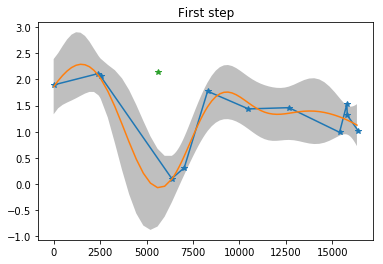

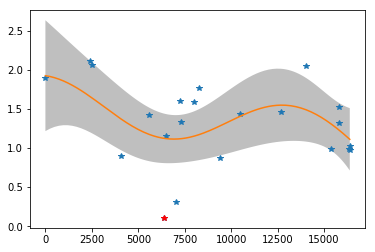

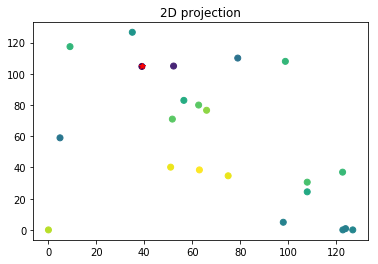

In [3]:
# Model function

# define the model interface. This is a simple test.
model = NDtestfunc(ND)

# initial points are random along the Hilbert curve
N0 = 10
x0 = []
y0 = []
x0.append(0.)
[x0.append(rm.random()*hutil.imax) for _ in range(N0)]
x0.append(hutil.imax)

x0 = np.sort(x0)

# To retreive coordinates, we have to scale by 2^p. opt will minimize,
# hence we append the negative of the merit function:
[y0.append(-model.getMerit(hutil.interp_coords_from_dist(xx)/2.**hutil.p)) 
 for xx in x0]

opt.addpoints(x0, y0)

newx = opt.nextstep()
newy = []
[newy.append(-model.getMerit(hutil.interp_coords_from_dist(xx))) 
 for xx in newx]

if scheme==1:
    xt1 = opt.xt
    mean1 = np.squeeze(opt.mean)
    var1 = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )


conv = opt.minimize_parameters(model, hutil)

print ("Convergence: " + str(conv) + " after " + str(opt.iter) + " iterations.")

optpointHC = opt.getbest()
optpointND = hutil.interp_coords_from_dist(optpointHC[0])



points = []
xND = []
yND = []
for x in opt.x:
    point = hutil.interp_coords_from_dist(x)
    xND.append(point[0])
    yND.append(point[1])
    points.append(point)
    
# plotting the results:

pl.figure(1)
pl.plot(x0, y0, '-*')

if scheme==1:
    pl.plot(xt1, mean1)
    pl.fill_between(np.squeeze(xt1), mean1-np.squeeze(2*np.sqrt(var1)),
                    mean1+np.squeeze(2*np.sqrt(var1)), 
                    facecolor = "grey", alpha=0.5)
    
pl.plot(newx, newy, '*')
pl.title("First step")

pl.figure(2)
if scheme==0:
    pl.plot(opt.x, opt.y, '-*')
elif scheme==1:
    pl.plot(opt.x, opt.y, '*')
    
pl.plot(opt.getbest()[0], opt.getbest()[1], 'r*')

if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)

pl.figure(3)

pl.scatter(xND, yND, c=np.squeeze(opt.y))
pl.title("2D projection")
pl.hold
pl.plot(optpointND[0], optpointND[1], 'r*')

pl.show()



## Optimizing a QC structure with a simulation model

Dim = 6, p = 7, imax = 4398046511103, pmax = 127
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...


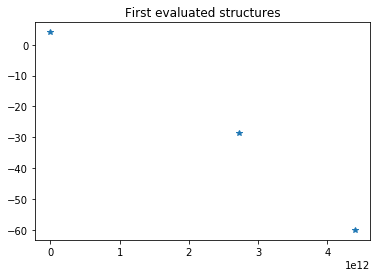

old theta =  [10, 1466015503701.0, 0.05] [27.66316639]
Optimization terminated successfully.
         Current function value: 14.727280
         Iterations: 5
         Function evaluations: 17
         Gradient evaluations: 17
new theta =  [3.48160846e+01 1.46601550e+12 1.44404293e-01] [14.72728015]
old theta =  [10, 1099511627775.75, 0.05] [705.50587462]
         Current function value: 25.034974
         Iterations: 26
         Function evaluations: 1315
         Gradient evaluations: 1304
new theta =  [1.81540609e+02 1.09951163e+12 5.00000000e+00] [25.03497424]
old theta =  [10, 879609302220.6, 0.05] [369.28953211]
         Current function value: 29.641279
         Iterations: 8
         Function evaluations: 215
         Gradient evaluations: 203
new theta =  [1.15852949e+02 8.79609302e+11 5.00000000e+00] [29.64127892]
old theta =  [10, 733007751850.5, 0.05] [44447.49789156]
         Current function value: 49.139700
         Iterations: 100
         Function evaluations: 4602
   

In [ ]:
from interface.isewlab import Isewlab
from utils.qcls import *
from structure.sgenerator import Sgenerator
from numerics.runplatf import Local
from structure.materials import GaAs
import utils.systemutil as su

s = EV2416()

dw = []
[dw.append(l.width*0.10) for l in s.layers]

sg = Sgenerator(s, dw)
# keep binpath = "" if binary is in main path
binpath = ""
su.mkdir("demo/")
wdpath = su.abspath("demo/")
pltfm = Local()

Ns = 3
coords = sg.genRanHilbertStructs(Ns, p)

# Choose your model:
# model = Inegf(binpath, pltfm, GaAs() )
# model = Isewself(binpath, pltfm, [GaAs(), AlGaAs(x=0.15)])
model = Isewlab(binpath + "sewlab_MAC", pltfm, GaAs())

model.numpar["efield0"] = 20
model.absorption_params["min-photon-energy"] = 0.010
model.absorption_params["max-photon-energy"] = 0.020

model.runStructures(sg.structures, wdpath)
model.waitforproc(3, "Simulation is running...")
model.gatherResults(sg.structures, wdpath)
opt.x = []
opt.y = []
x0, y0 = opt.addEvaldPoints(model, sg, wdpath, coords)

pl.figure(6)
pl.plot(x0, y0, '*')
pl.title("First evaluated structures")
pl.show()

conv = opt.minimize(model, sg, wdpath)

print( "Convergence: " + str(conv) )

pl.figure(7)
pl.plot(opt.x,opt.y,'*')
if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)
pl.show()